Time taken for Grid Search training (5 iterations): 4068 seconds
Average time taken for each Grid Search iteration: 813.6 seconds

Time taken for HySEOpt training (5 iterations): 1875 seconds (31 minutes and 15 seconds)
Average time taken for each HySEOpt iteration: 375.0 seconds

Time taken for Evolutionary Algorithm training (5 iterations): 2160 seconds
Average time taken for each Evolutionary Algorithm iteration: 432.0 seconds

Time taken for Regular Swarm Algorithm training (5 iterations): 2580 seconds
Average time taken for each Regular Swarm Algorithm iteration: 516.0 seconds


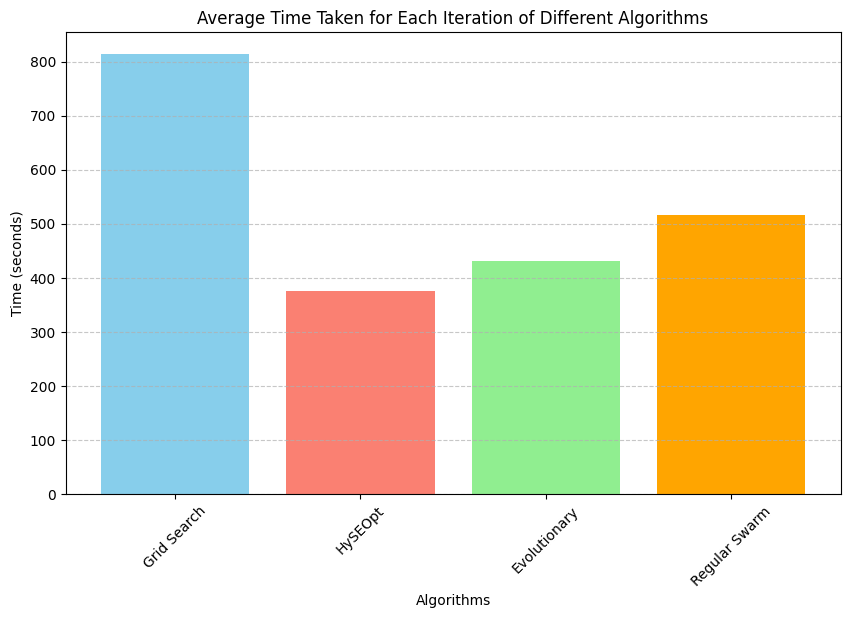

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import time

# Define the HySEOpt hyperparameter optimization algorithm
class HySEOpt:
    def __init__(self, max_iter=5, swarm_size=50, n_estimators=100, mutation_rate=0.1, parallel=True,
                 initial_mutation_rate=0.1, mutation_rate_decay=0.9):
        self.max_iter = max_iter
        self.swarm_size = swarm_size
        self.n_estimators = n_estimators
        self.mutation_rate = mutation_rate
        self.best_params = {'n_estimators': n_estimators}
        self.best_score = 0
        self.validation_scores = []  
        self.parallel = parallel
        self.initial_mutation_rate = initial_mutation_rate
        self.mutation_rate_decay = mutation_rate_decay
        self.current_mutation_rate = initial_mutation_rate  

    def _update_mutation_rate(self):
        self.current_mutation_rate *= self.mutation_rate_decay

    def _evaluate_agent(self, agent, X_train, y_train, X_validation, y_validation):
        clf = RandomForestClassifier(**agent, random_state=42)
        clf.fit(X_train, y_train)
        val_score = accuracy_score(y_validation, clf.predict(X_validation))
        return agent, val_score

    def _mutate(self, agent):
        mutated_agent = agent.copy()
        for param in mutated_agent:
            if np.random.rand() < self.current_mutation_rate:
                if param == 'n_estimators':
                    mutated_agent[param] = np.random.randint(max(1, agent[param] - 10), agent[param] + 10)
                elif param == 'min_samples_leaf':
                    mutated_agent[param] = np.random.randint(1, 11)
                else:
                    mutated_agent[param] = np.random.randint(1, 11)
        return mutated_agent

    def fit(self, X_train, y_train, X_validation, y_validation):
        for i in range(self.max_iter):
            swarm = [self._mutate(self.best_params) for _ in range(self.swarm_size)]
            if self.parallel:
                scores = [self._evaluate_agent(agent, X_train, y_train, X_validation, y_validation) for agent in swarm]
            else:
                scores = [self._evaluate_agent(agent, X_train, y_train, X_validation, y_validation) for agent in swarm]
                
            best_agent, best_score = max(scores, key=lambda x: x[1])
            if best_score > self.best_score:
                self.best_score = best_score
                self.best_params = best_agent

            self.validation_scores.append(best_score)
            print(f"Iteration {i + 1} - : Accuracy {'{0:.2%}'.format(best_score)}")
            self._update_mutation_rate()  

        print(f"Final Model Accuracy: {self.best_score:.4f}")


# Define Evolutionary Algorithm
class EvolutionaryAlgorithm:
    def __init__(self, max_iter=5, population_size=50, n_estimators=100, mutation_rate=0.1):
        self.max_iter = max_iter
        self.population_size = population_size
        self.n_estimators = n_estimators
        self.mutation_rate = mutation_rate
        self.best_params = {'n_estimators': n_estimators}
        self.best_score = 0
        self.validation_scores = []

    def _mutate(self, agent):
        mutated_agent = agent.copy()
        for param in mutated_agent:
            if np.random.rand() < self.mutation_rate:
                if param == 'n_estimators':
                    mutated_agent[param] = np.random.randint(max(1, agent[param] - 10), agent[param] + 10)
                elif param == 'min_samples_leaf':
                    mutated_agent[param] = np.random.randint(1, 11)
                else:
                    mutated_agent[param] = np.random.randint(1, 11)
        return mutated_agent

    def fit(self, X_train, y_train, X_validation, y_validation):
        for i in range(self.max_iter):
            population = [self._mutate(self.best_params) for _ in range(self.population_size)]
            scores = []
            for agent in population:
                clf = RandomForestClassifier(**agent, random_state=42)
                clf.fit(X_train, y_train)
                val_score = accuracy_score(y_validation, clf.predict(X_validation))
                scores.append((agent, val_score))
            best_agent, best_score = max(scores, key=lambda x: x[1])
            if best_score > self.best_score:
                self.best_score = best_score
                self.best_params = best_agent
            self.validation_scores.append(best_score)
            print(f"Iteration {i + 1} - : Accuracy {'{0:.2%}'.format(best_score)}")
        print(f"Final Model Accuracy: {self.best_score:.4f}")


# Define Simple Swarm Algorithm
class SwarmAlgorithm:
    def __init__(self, max_iter=5, swarm_size=50, n_estimators=100):
        self.max_iter = max_iter
        self.swarm_size = swarm_size
        self.n_estimators = n_estimators
        self.best_params = {'n_estimators': n_estimators}
        self.best_score = 0
        self.validation_scores = []

    def _update_params(self, swarm):
        for agent in swarm:
            clf = RandomForestClassifier(**agent, random_state=42)
            clf.fit(X_train_resampled_partial, y_train_resampled_partial)
            val_score = accuracy_score(y_validation, clf.predict(X_validation))
            if val_score > self.best_score:
                self.best_score = val_score
                self.best_params = agent
            self.validation_scores.append(val_score)

    def fit(self, X_train, y_train, X_validation, y_validation):
        swarm = [self.best_params.copy() for _ in range(self.swarm_size)]
        for i in range(self.max_iter):
            self._update_params(swarm)
            print(f"Iteration {i + 1} - : Accuracy {'{0:.2%}'.format(self.best_score)}")
        print(f"Final Model Accuracy: {self.best_score:.4f}")


# Load and preprocess data
df = pd.read_csv('/kaggle/input/personal-key-indicators-of-heart-disease/2022/heart_2022_no_nans.csv')
replacement_dict = {'Yes': 1, 'No': 0}
df['HadHeartAttack'] = df['HadHeartAttack'].replace(replacement_dict).infer_objects(copy=False)
df['HadAngina'] = df['HadAngina'].replace(replacement_dict).infer_objects(copy=False)
df['HeartDisease'] = df['HadHeartAttack'] | df['HadAngina']
df.drop(columns=['HadHeartAttack', 'HadAngina', 'WeightInKilograms'], inplace=True)
df_categorical = df.select_dtypes('object').columns
preprocessor = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), df_categorical)], remainder='passthrough')
X_transformed = preprocessor.fit_transform(df.drop(columns='HeartDisease'))
target = df['HeartDisease']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, target, test_size=0.2, random_state=42)

# Handle class imbalance
over = SMOTE(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=0.6)
X_train_resampled, y_train_resampled = under.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_resampled, y_train_resampled)
X_train_resampled_partial, X_validation, y_train_resampled_partial, y_validation = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
start = time.time()
grid_search.fit(X_train_resampled_partial, y_train_resampled_partial)
end = time.time()
grid_search_time = end - start
grid_search_accuracy = grid_search.best_score_
print(f"Time taken for Grid Search training (5 iterations): {grid_search_time:.0f} seconds")
print(f"Average time taken for each Grid Search iteration: {grid_search_time / 5:.1f} seconds")


# HySEOpt
start = time.time()
hyseopt = HySEOpt(max_iter=5, swarm_size=50, n_estimators=100, mutation_rate=0.1)
hyseopt.fit(X_train_resampled_partial, y_train_resampled_partial, X_validation, y_validation)
end = time.time()
hyseopt_time = end - start
print(f"Time taken for HySEOpt training (5 iterations): {hyseopt_time:.0f} seconds")
print(f"Average time taken for each HySEOpt iteration: {hyseopt_time / 5:.1f} seconds")

# Evolutionary Algorithm
start = time.time()
evolutionary = EvolutionaryAlgorithm(max_iter=5, population_size=50, n_estimators=100, mutation_rate=0.1)
evolutionary.fit(X_train_resampled_partial, y_train_resampled_partial, X_validation, y_validation)
end = time.time()
evolutionary_time = end - start
print(f"Time taken for Evolutionary Algorithm training (5 iterations): {evolutionary_time:.0f} seconds")
print(f"Average time taken for each Evolutionary Algorithm iteration: {evolutionary_time / 5:.1f} seconds")

# Simple Swarm Algorithm
start = time.time()
swarm = SwarmAlgorithm(max_iter=5, swarm_size=50, n_estimators=100)
swarm.fit(X_train_resampled_partial, y_train_resampled_partial, X_validation, y_validation)
end = time.time()
swarm_time = end - start
print(f"Time taken for Simple Swarm Algorithm training (5 iterations): {swarm_time:.0f} seconds")
print(f"Average time taken for each Simple Swarm Algorithm iteration: {swarm_time / 5:.1f} seconds")

# Plot time comparison
labels = ['Grid Search', 'HySEOpt', 'Evolutionary Algorithm', 'Simple Swarm Algorithm']
times = [grid_search_time, hyseopt_time, evolutionary_time, swarm_time]

plt.figure(figsize=(10, 6))
plt.bar(labels, times, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Algorithm')
plt.ylabel('Time (seconds)')
plt.title('Time Comparison between Different Algorithms')
plt.show()
